In [1]:
import os
import pandas as pd
import seaborn as sns
from itertools import product
from os.path import join as pj
import matplotlib.pyplot as plt
from faket.data import load_mrc

# Creating the figures for the paper

In [45]:
def plot_tilt(projections, tilt=30, title=''):
    plt.figure(dpi=200)
    plt.title(title)
    plt.imshow(projections[tilt,:,:])
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [46]:
plt.rcParams['font.family'] = 'serif'
data_folder = 'data/shrec2021_extended_dataset'
N = 0

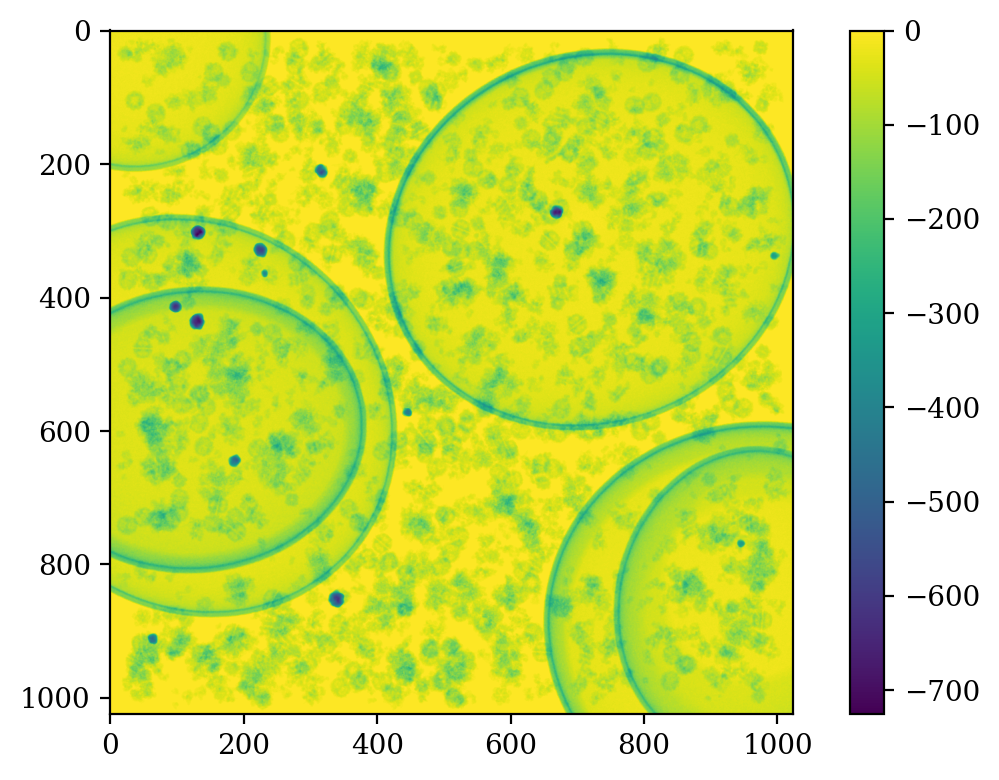

In [47]:
# Noiseless projection
plot_tilt(load_mrc(pj(data_folder, f'model_{N}', 'faket', 'projections_noiseless.mrc')))

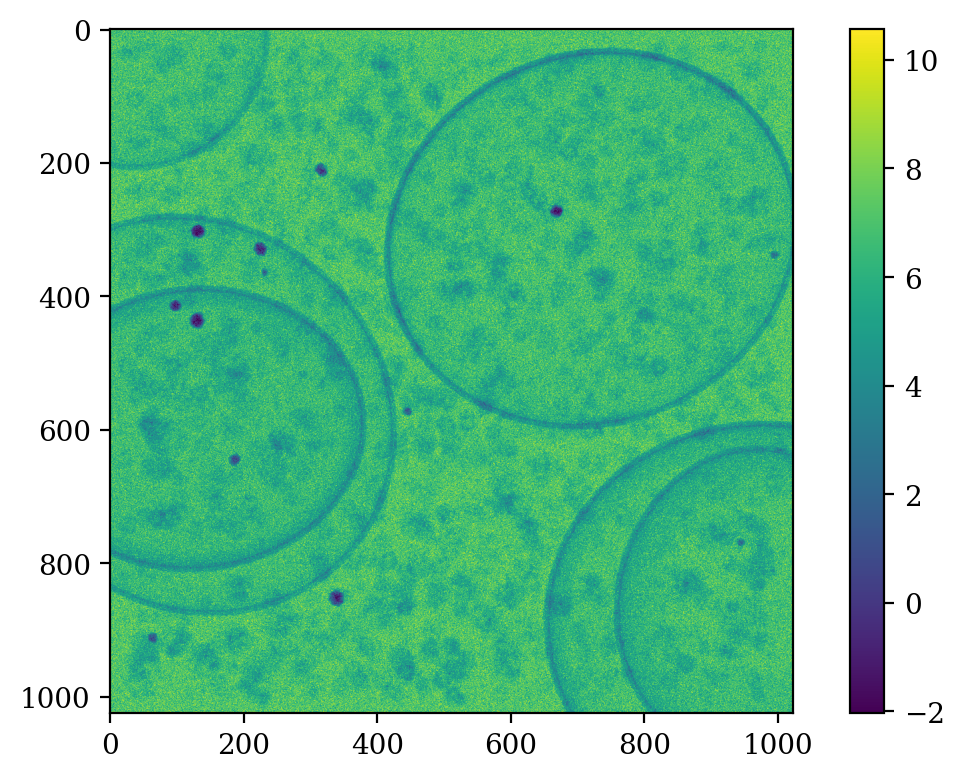

In [48]:
# Content projection
plot_tilt(load_mrc(pj(data_folder, f'model_{N}', 'faket', 'projections_content.mrc')))

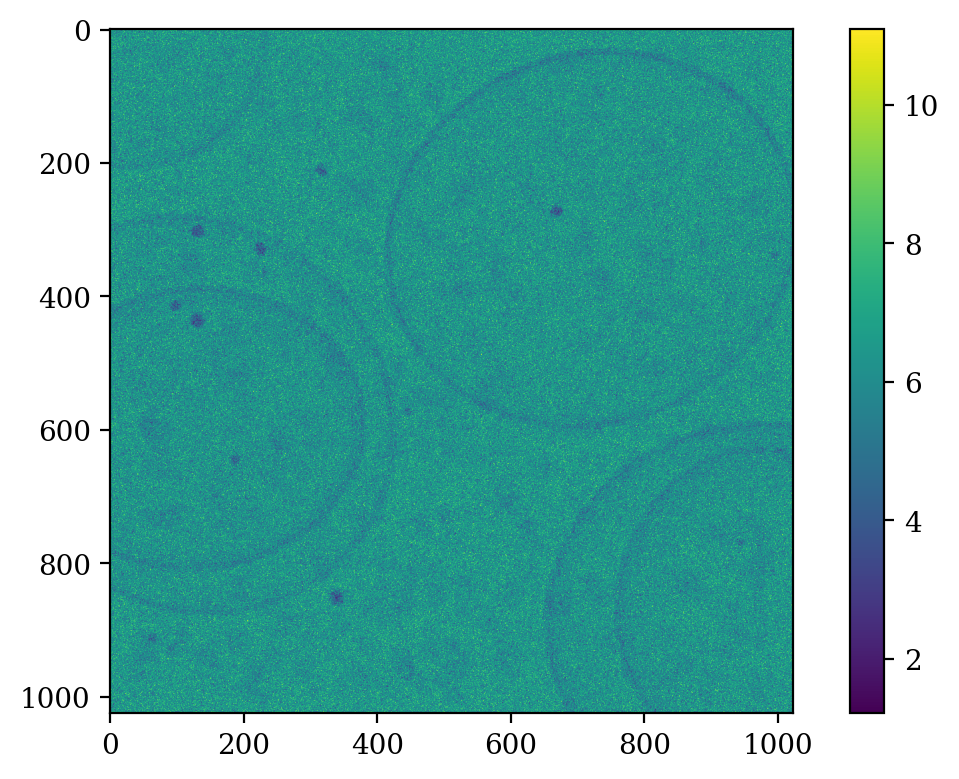

In [49]:
# Noisy projection
plot_tilt(load_mrc(pj(data_folder, f'model_{N}', 'faket', 'projections_noisy.mrc')))

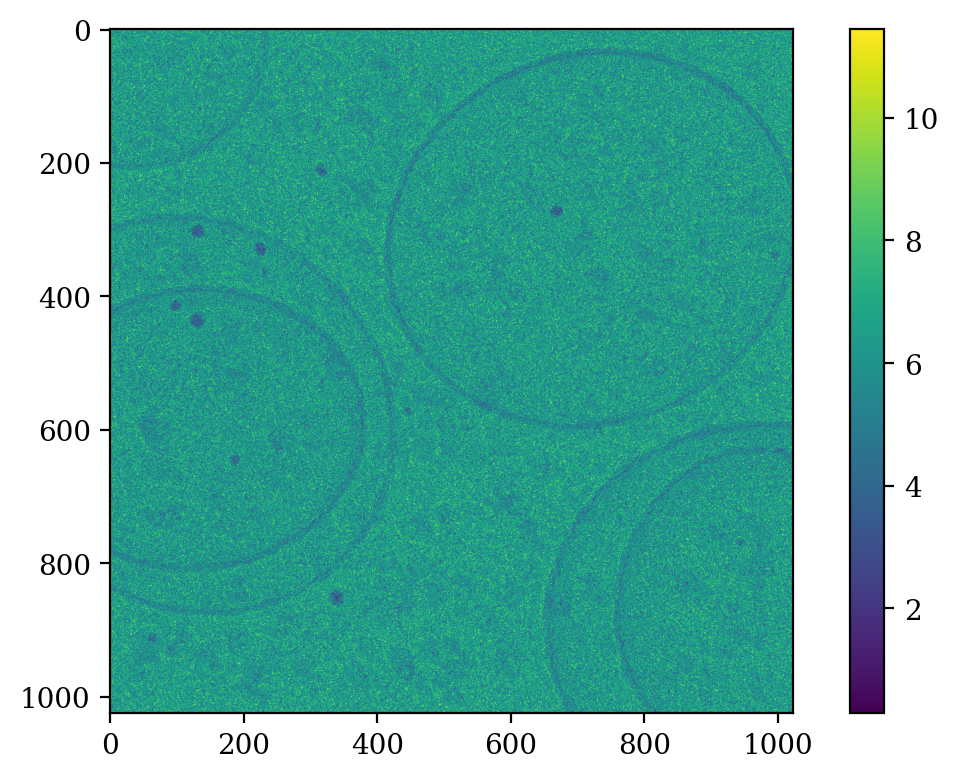

In [51]:
# Styled projection
plot_tilt(load_mrc(pj(data_folder, f'model_{N}', 'faket', 'projections_styled.mrc')))

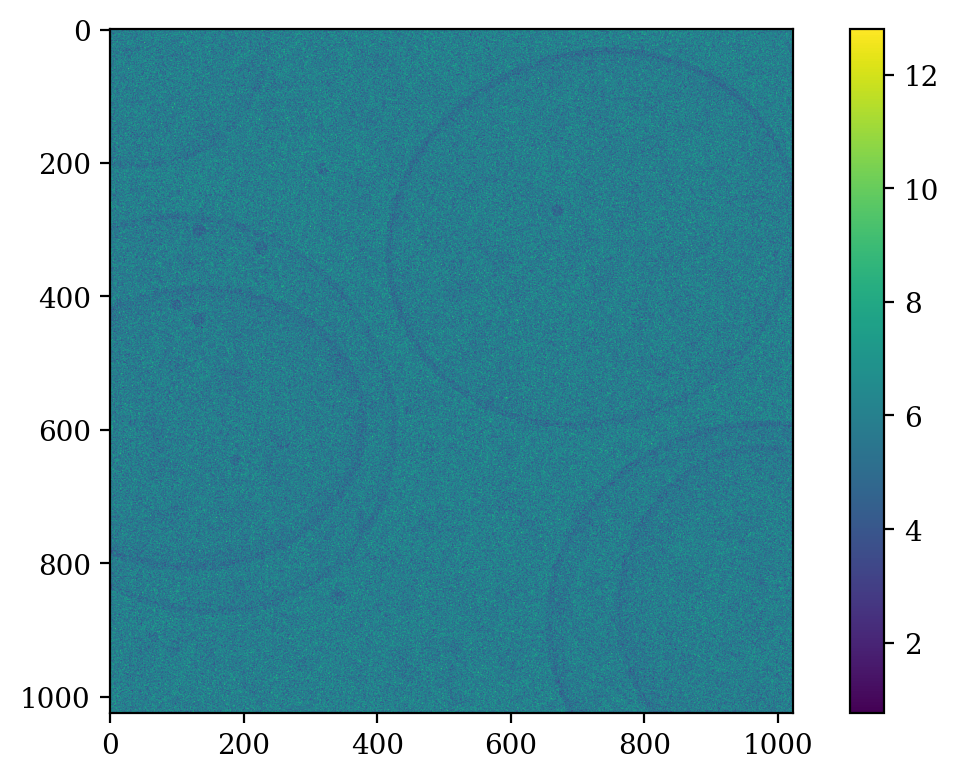

In [52]:
# Desired projection (SHREC21)
plot_tilt(load_mrc(pj(data_folder, f'model_{N}', 'projections.mrc')))

In [6]:
# Performance on localization task

In [7]:
# Performance on classification task

In [8]:
# Confusion matrix (baseline) at best epoch

In [9]:
# Confusion matrix (content) at best epoch

In [10]:
# Confusion matrix (noisy) at best epoch

In [11]:
# Confusion matrix (styled) at best epoch

In [84]:
def parse_report(path):
    """
    Reads the txt report, and returns the F1 and F1 Macro scores.
    """
    with open(path, 'r') as file:
        lines = file.readlines()
        i = [i for i, line in enumerate(lines) if 'F1 score:' in line]
        j = [j for j, line in enumerate(lines) if 'F1 Macro' in line]
        f1 = lines[i[0]].strip().split(' ')[-1]
        f1m = lines[j[0]].strip().split(' ')[-1]
        return float(f1), float(f1m)

    
def get_dataframe(path, folders, folder2method, test_tomos, epochs, seeds):
    """
    Visits the `folders` at `path`, finds the report.txt files according to 
    """
    df = pd.DataFrame(columns=['TEST_TOMO', 'METHOD', 'SEED', 'EPOCH', 'F1 SCORE', 'F1 MACRO SCORE'])
    for tomo in test_tomos:
        for folder in folders:
            for epoch in epochs:
                for seed in seeds:
                    template = folder2method[folder]['template']
                    fp = pj(path, folder, seed, template.format(tomo, epoch))
                    f1, f1m = parse_report(fp)
                    df = pd.concat([df, pd.DataFrame({
                        'TEST_TOMO': [tomo],
                        'METHOD': [folder2method[folder]['method']],
                        'SEED': [seed],
                        'EPOCH': [epoch],
                        'F1 SCORE': [f1],
                        'F1 MACRO SCORE': [f1m],
                        'report_path': [fp],
                    })], axis=0, ignore_index=True)
    return df
                            

def plot_method_comparison(df, task='localization'):
    """
    Expects a pandas dataframe with experiment results in the following format:
    -----------------------------------------------------------------------------
    IDX, TEST_TOMO, METHOD,   SEED,  EPOCH, F1 SCORE, F1 MACRO SCORE, report_path
    -----------------------------------------------------------------------------
    0,   baseline   baseline, seed1, 1,     0.61963,  0.17095,        data/rep...
    ...
    -----------------------------------------------------------------------------
    So one epoch result per row. 
    
    Plots the mean performance of each method's model at specified epoch numbers.
    Results are plotted with two confidence intervals based on the results from the
    specified seeds. The confidence intervals are computed using bootstrapping.
    """
    
    if task == 'localization':
        metric, ylim_lo, ylim_hi, yticks = 'F1 SCORE', 0.2, 0.8, 16  # Fig 6.
    elif task == 'classification':
        metric, ylim_lo, ylim_hi, yticks = 'F1 MACRO SCORE', 0.0, 0.52, 14  # Fig 7.
    else:
        raise NotImplementedError('Task must be one of {"localization", "classification"}')

    sns.set_style(['dark', 'white', 'whitegrid', 'darkgrid', 'ticks'][4])
    plt.rcParams['font.family'] = 'serif'
    import matplotlib.ticker as ticker
    plt.figure(figsize=(7,6), dpi=200)

    plot = sns.lineplot(x='EPOCH', y=metric, data=df, seed=0, hue="METHOD", marker='o', 
                        err_style='band', legend=False, ci=95, n_boot=500, markersize=0, alpha=0)
    plot = sns.lineplot(x='EPOCH', y=metric, data=df, seed=0, hue="METHOD", marker='o', 
                        err_style='band', legend='brief', ci=68, n_boot=500, markersize=8)

    plot.set_xticks(epochs)
    plot.set_ylim(ylim_lo, ylim_hi)
    plot.yaxis.set_major_locator(ticker.LinearLocator(yticks))

    # Setting alpha of the bands (ci=95)
    for ch in [1, 3, 5, 7]:
        plot.get_children()[ch].set_alpha(0.1)

    # Setting alpha of the bands (ci=68)
    for ch in [9, 11, 13, 15]:
        plot.get_children()[ch].set_alpha(0.15)
    
    plt.show()

In [81]:
################################################################################################
# NEW EXPERIMENTS
################################################################################################
# Path to the folder where the result folders are stored
path = 'data/results/exp_styled_mult_cont_feat_layers/'

# The following dict holds the map from folder_name to {method and report_file_name_template}
# It would be ideal, if the templates always had the same structure and that the folder name itself
# would be named after the method, so we would not have 'exp1' but instead we would have 'baseline'.
folder2method = {
    'exp1': {'method': 'baseline', 'template': 'report_{}_{}epochs_bin1_2021.txt'}, 
    'exp2': {'method': 'content', 'template': 'report_{}_{}epochs_bin1_2021.txt'}, 
    'exp3': {'method': 'noisy', 'template': 'report_{}_{}epochs_bin1_2021.txt'}, 
    'exp4': {'method': 'styled', 'template': 'tomo9_{}_2021_{}epoch_bin1_2021.txt'}}

################################################################################################
# OLD EXPERIMENTS
################################################################################################
# path = 'data/reports_10seeds'
# folder2method = {
#     'exp1': {'method': 'baseline', 'template': 'report_{}_{}epochs_bin1_2021.txt'}, 
#     'exp2': {'method': 'content', 'template': 'report_{}_{}epochs_bin1_2021.txt'}, 
#     'exp3': {'method': 'noisy', 'template': 'report_{}_{}epochs_bin1_2021.txt'}, 
#     'exp4': {'method': 'styled', 'template': 'report_{}_{}epochs_bin1_2021.txt'}}

# List of the folders, seeds, epochs, and test_tomos to include in the figures
folders = list(folder2method.keys())
seeds = [f'seed{i}' for i in range(1,11)]
epochs = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]
test_tomos = ['baseline']

df = get_dataframe(path, folders, folder2method, test_tomos, epochs, seeds)

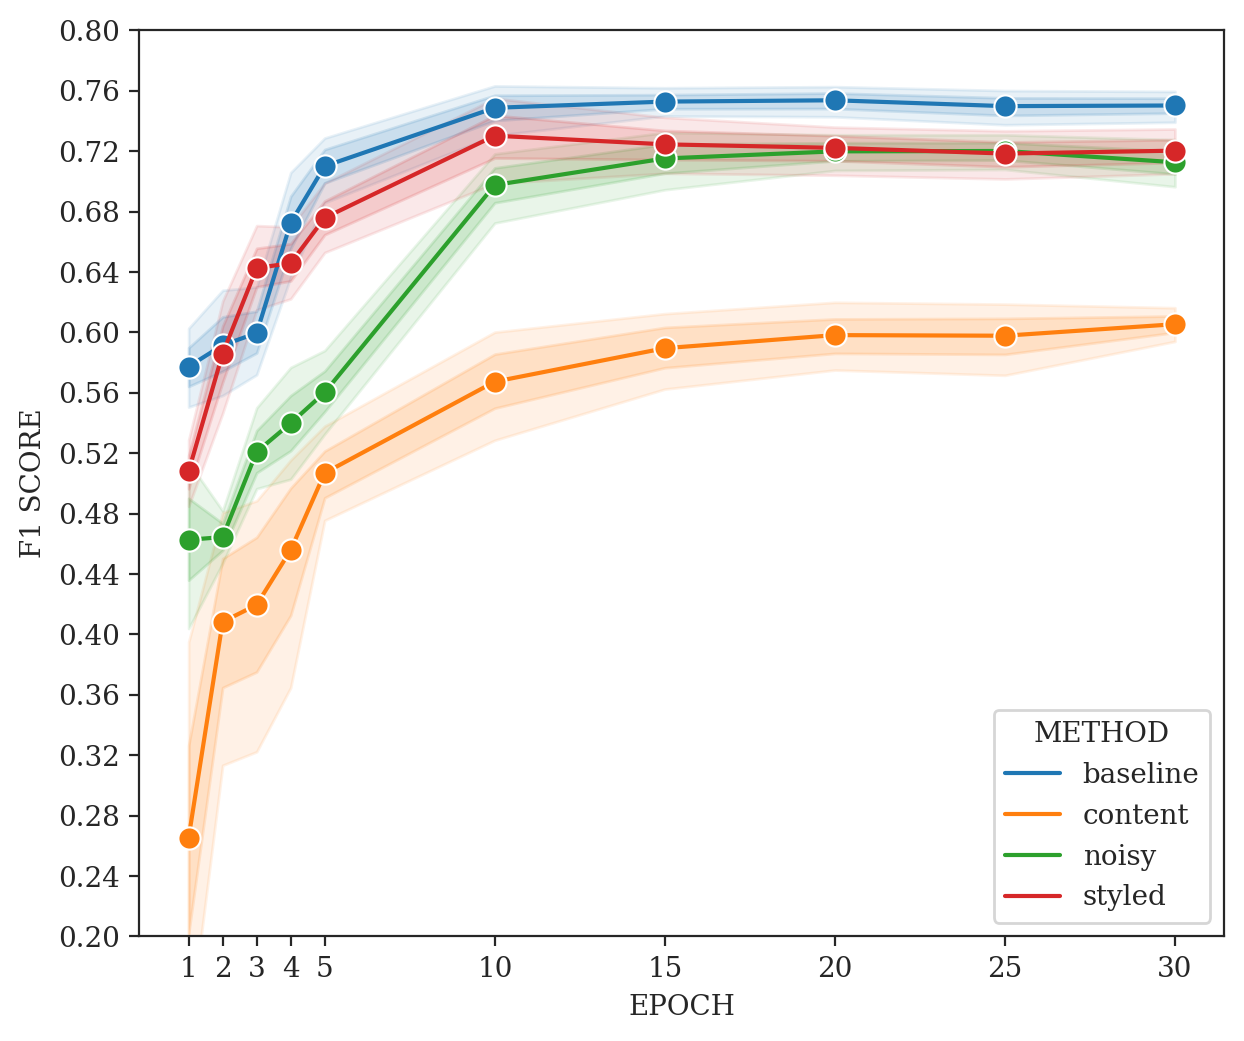

In [85]:
# Figure 6
plot_method_comparison(df, task='localization')

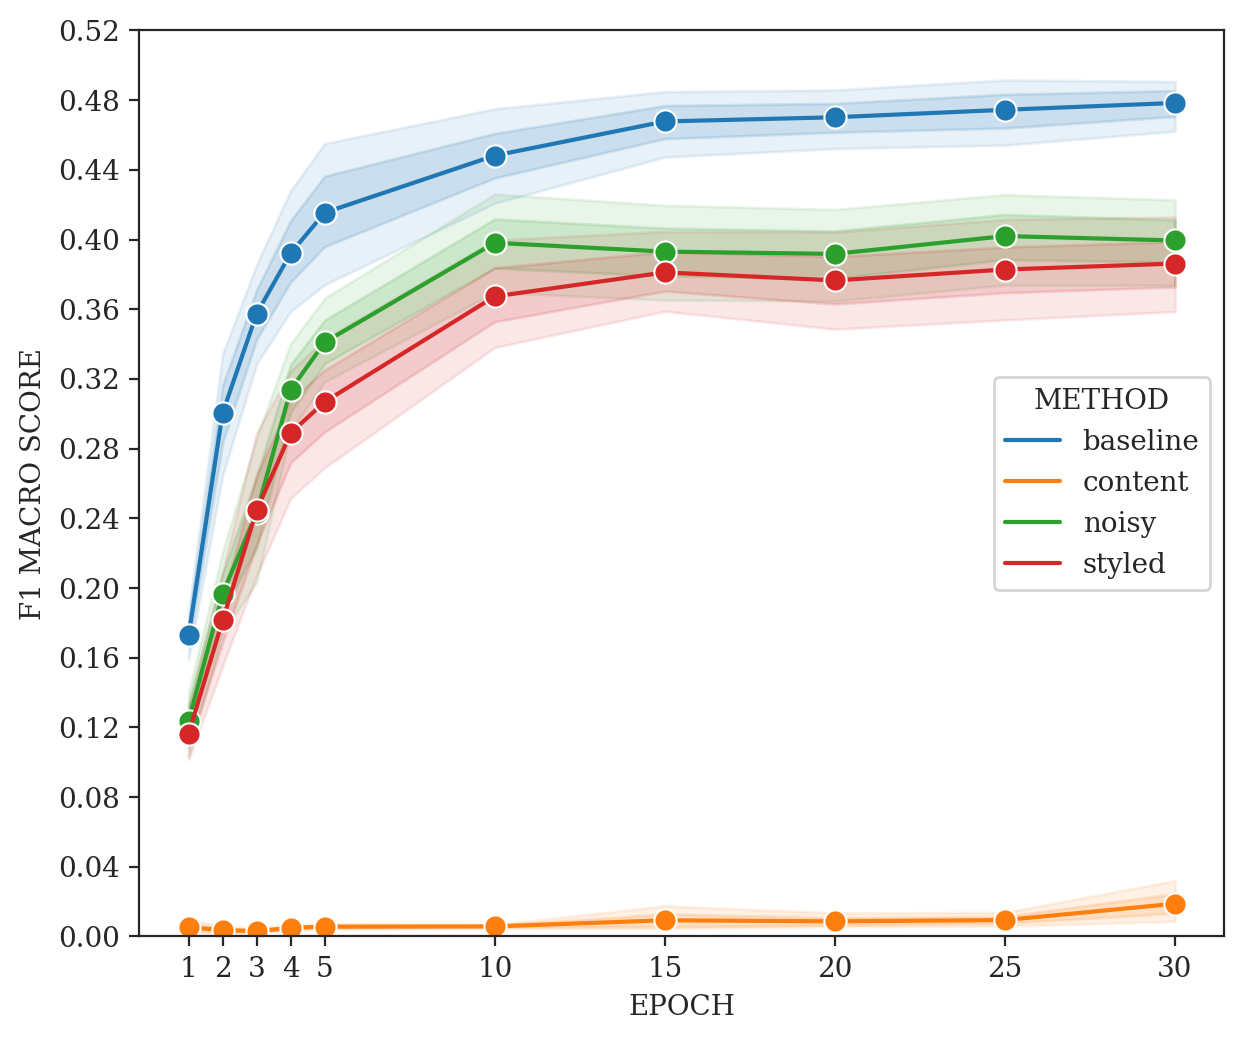

In [86]:
# Figure 7
plot_method_comparison(df, task='classification')